In [17]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import seaborn as sns
import plotly.express as px
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [18]:
df_1 = pd.read_parquet('IVE_ANALYTICS_LABEL_DATA.parquet')

In [19]:
ive_ml_label = df_1.groupby('MASTER_LABEL')[['CVR','ABS', '1000_W_EFFICIENCY']].mean().reset_index()
ive_ml_label.columns = ['MASTER_LABEL', 'avg_CVR', 'avg_ABS', 'avg_1000_W_EFFICIENCY']

In [20]:
# 스케일링
X = ive_ml_label[['avg_CVR','avg_ABS', 'avg_1000_W_EFFICIENCY']]
X_scaled = RobustScaler().fit_transform(X)

# K 1 ~ 10 까지 wcss
wcss = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# 시각화
fig = px.line(
    x=K_range, y=wcss, markers=True,
    title='Elbow Method — K에 따른 WCSS 변화',
    labels={'x': 'K (군집 개수)', 'y': 'WCSS'},
    template='plotly_dark'
)
fig.update_layout(width=750, height=500)
fig.show()

In [21]:
# silhouette_scores 확인
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

fig = px.bar(
    x=list(range(2, 11)), y=silhouette_scores,
    title='Silhouette Score — 군집 품질 비교',
    labels={'x': 'K (군집 개수)', 'y': 'Silhouette Score'},
    template='plotly_dark'
)
fig.update_layout(width=700, height=450)
fig.show()

In [22]:
# K값 5 K-means Clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
ive_ml_label['Cluster'] = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = ive_ml_label['Cluster']

cluster_labels_order = [str(i) for i in range(5)]

expl = pca.explained_variance_ratio_
fig_pca = px.scatter(
    df_pca, x='PC1', y='PC2', color=df_pca['Cluster'].astype(str),
    title='K-means PCA [5 Cluster]',
    category_orders={'color': cluster_labels_order}
)
fig_pca.update_traces(marker=dict(size=8, opacity=0.9))
fig_pca.update_layout(
    legend=dict(
        title = 'Cluster',
        x = 0.935,
        y = 0.48,
        xanchor = 'left',
        yanchor = 'top',
        bordercolor ="black",
        borderwidth=1,
    )
)
fig_pca.show()

In [23]:
# silhouette_score, davies_bouldin_score 확인
score = silhouette_score(X_scaled, ive_ml_label['Cluster'])
dbi = davies_bouldin_score(X_scaled, ive_ml_label['Cluster'])

print(f'silhouette_score: {score}')
print('------')
print(f'davies_bouldin_score: {dbi}')

silhouette_score: 0.5286422967910767
------
davies_bouldin_score: 0.7084251297525517


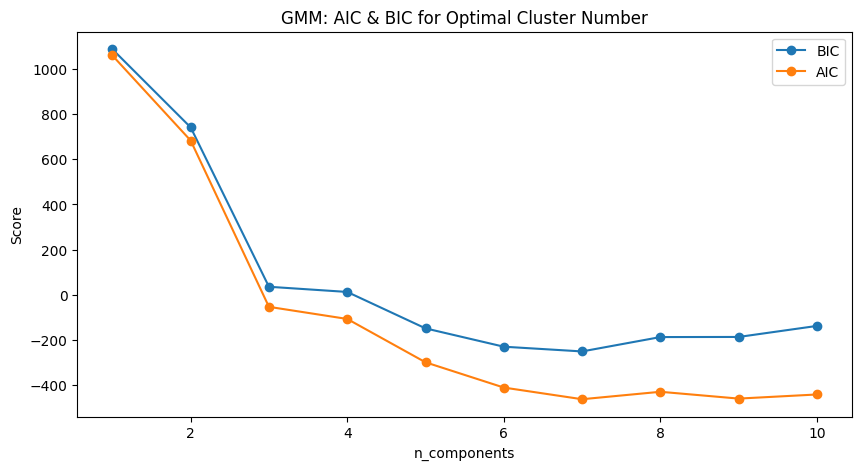

In [25]:
# 1. AIC/BIC 측정을 위한 루프
n_components = np.arange(1, 11)
models = [GaussianMixture(n, covariance_type='full', random_state=42).fit(X_scaled) for n in n_components]

# 2. 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(n_components, [m.bic(X_scaled) for m in models], label='BIC', marker='o')
plt.plot(n_components, [m.aic(X_scaled) for m in models], label='AIC', marker='o')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('Score')
plt.title('GMM: AIC & BIC for Optimal Cluster Number')
plt.show()

In [26]:
# n_components를 7로 설정하여 학습
gmm_final = GaussianMixture(n_components=7, covariance_type='full', random_state=42)
gmm_labels = gmm_final.fit_predict(X_scaled)

# 4. 결과 저장
ive_ml_label['GMM_Cluster'] = gmm_labels

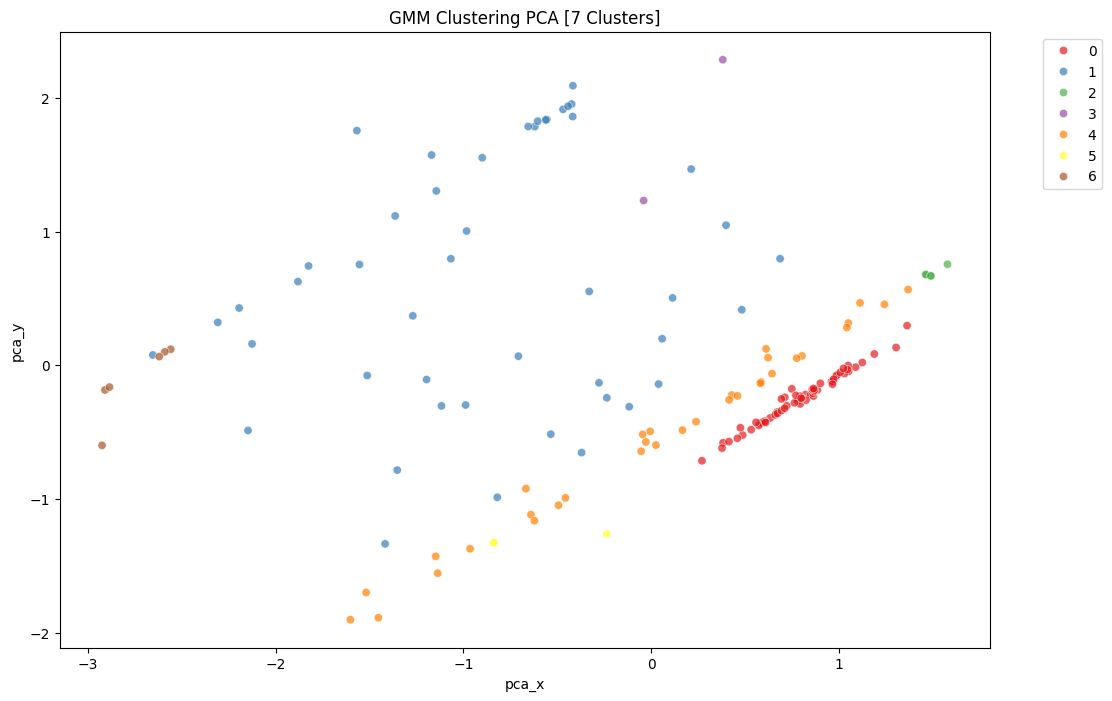

In [27]:
# 1. PCA 객체 생성 및 변환 (2차원)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
ive_ml_label['pca_x'] = pca_result[:, 0]
ive_ml_label['pca_y'] = pca_result[:, 1]

# 2. 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='pca_x', y='pca_y', 
    hue='GMM_Cluster', # GMM 레이블 컬럼명
    palette='Set1',    # 7개 군집을 구분하기 좋은 색상 팔레트
    data=ive_ml_label,
    alpha=0.7
)
plt.title('GMM Clustering PCA [7 Clusters]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

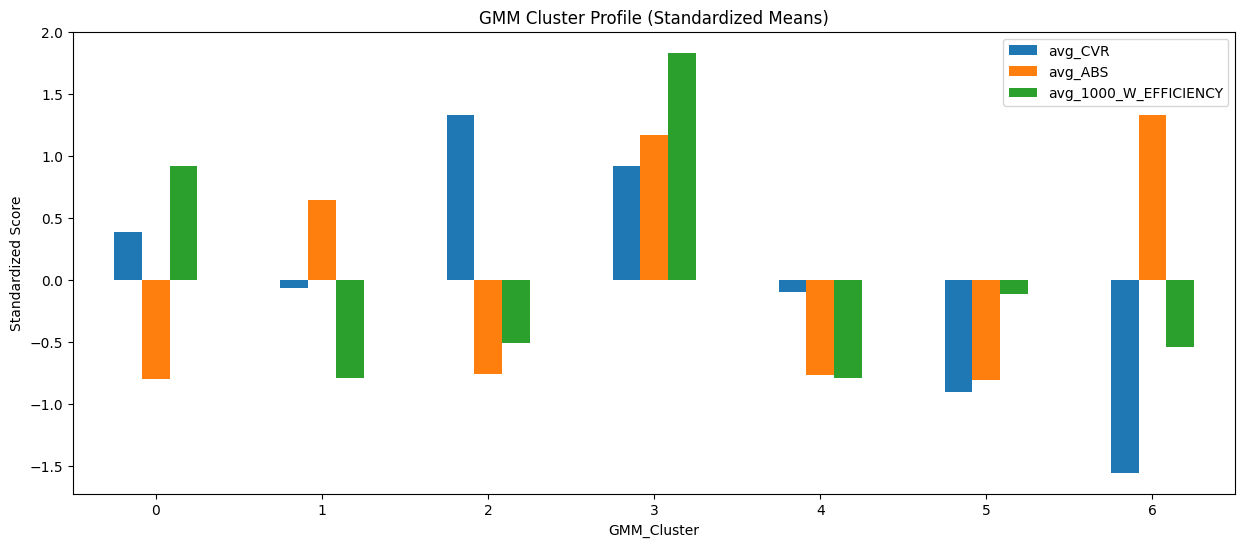

In [28]:
# 군집별 평균 지표 계산
cluster_profile = ive_ml_label.groupby('GMM_Cluster')[['avg_CVR', 'avg_ABS', 'avg_1000_W_EFFICIENCY']].mean()

# 스케일이 다르므로 표준화하여 시각화하면 비교가 더 쉽습니다
cluster_profile_norm = (cluster_profile - cluster_profile.mean()) / cluster_profile.std()

cluster_profile_norm.plot(kind='bar', figsize=(15, 6))
plt.title('GMM Cluster Profile (Standardized Means)')
plt.ylabel('Standardized Score')
plt.xticks(rotation=0)
plt.legend(loc='best')
plt.show()

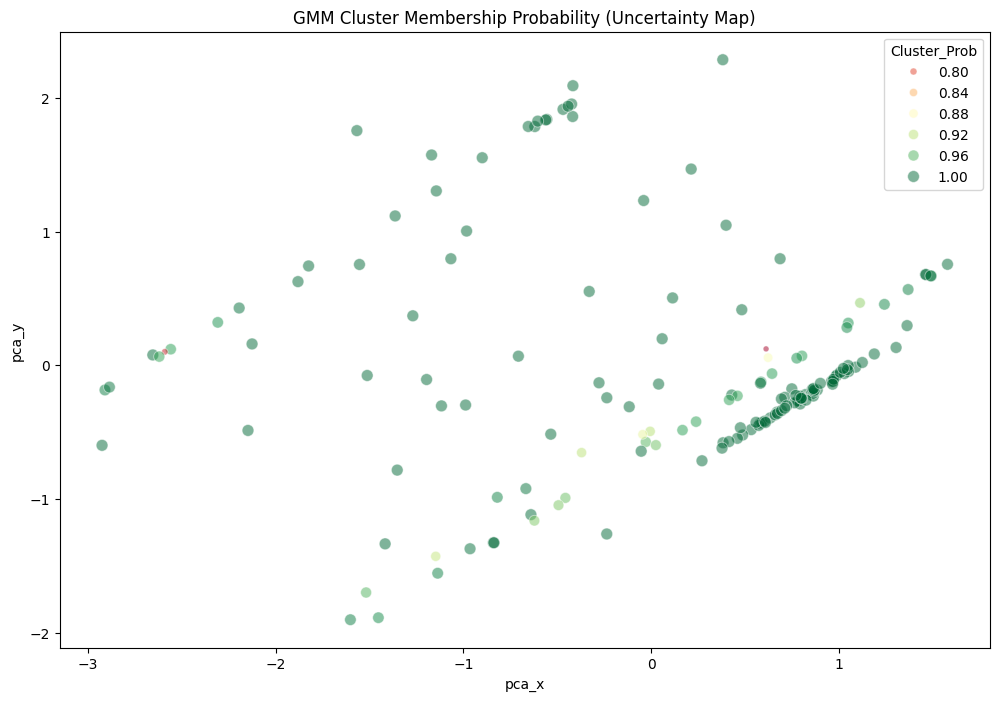

In [29]:
probs = gmm_final.predict_proba(X_scaled)

# 2. 가장 높은 확률값을 'Cluster_Prob' 컬럼으로 저장합니다.
ive_ml_label['Cluster_Prob'] = probs.max(axis=1).round(4)

plt.figure(figsize=(12, 8))
# 확률이 낮을수록(경계선에 있을수록) 빨간색/작은 점으로 표시
sns.scatterplot(
    x='pca_x', y='pca_y', 
    hue='Cluster_Prob', # 이전 단계에서 만든 확률 컬럼
    size='Cluster_Prob',
    palette='RdYlGn',   # 확률 높으면 초록, 낮으면 빨강
    data=ive_ml_label,
    alpha=0.5
)
plt.title('GMM Cluster Membership Probability (Uncertainty Map)')
plt.show()

In [30]:
# 본 데이터와 클러스터 병합
ive_ml_merge = df_1.merge(ive_ml_label, how='left', on='MASTER_LABEL')

# 필요 칼럼 추출
ive_for_tableau = ive_ml_merge[['INDUSTRY', 'OS_TYPE', 'LIMIT_TYPE',
                                'SHAPE', 'MDA', 'START_TIME',
                                'CVR', 'ABS', '1000_W_EFFICIENCY',
                                'TIME_TURN',  'GMM_Cluster']]

# 군집별 데이터셋 분리
ive_cluster_0 = ive_for_tableau[ive_for_tableau['GMM_Cluster'] == 0]
ive_cluster_1 = ive_for_tableau[ive_for_tableau['GMM_Cluster'] == 1]
ive_cluster_2 = ive_for_tableau[ive_for_tableau['GMM_Cluster'] == 2]
ive_cluster_3 = ive_for_tableau[ive_for_tableau['GMM_Cluster'] == 3]
ive_cluster_4 = ive_for_tableau[ive_for_tableau['GMM_Cluster'] == 4]
ive_cluster_5 = ive_for_tableau[ive_for_tableau['GMM_Cluster'] == 5]
ive_cluster_6 = ive_for_tableau[ive_for_tableau['GMM_Cluster'] == 6]

In [31]:
# CVR 회귀
targets = ['CVR']
features = ['SHAPE', 'MDA', 'START_TIME']
cat_features = ['SHAPE', 'MDA', 'START_TIME']

results_0 = {}

print(f'{'Target':<6} | {'MAE':<10}')
print('-' * 45)

for target in targets:
    X = ive_cluster_0[features]
    y = ive_cluster_0[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model_cvr = CatBoostRegressor(
        iterations=3000,
        learning_rate=0.01,
        depth=10,
        cat_features=cat_features,
        verbose=200,
        loss_function='MAE',
        eval_metric='MAE',
        early_stopping_rounds=100,
        metric_period=1,
        task_type='GPU',
        devices='0'
    )

    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)

    # 모델 학습
    model_cvr.fit(
        X_train, y_train_log,
        eval_set=(X_test, y_test_log),
        use_best_model=True)
    
    # 모델 저장
    results_0[target] = model_cvr

    # 모델 평가
    y_pred_log = model_cvr.predict(X_test)
    y_pred_real = np.expm1(y_pred_log)
    mae = mean_absolute_error(y_test, y_pred_real)

    print(f'{target:<6} | {mae:9.4f}')

Target | MAE       
---------------------------------------------
0:	learn: 0.1269686	test: 0.1267383	best: 0.1267383 (0)	total: 53.3ms	remaining: 2m 39s
200:	learn: 0.0980101	test: 0.0977811	best: 0.0976790 (195)	total: 8.14s	remaining: 1m 53s
bestTest = 0.09755616385
bestIteration = 260
Shrink model to first 261 iterations.
CVR    |    0.1657


In [32]:
# 1000_W_EFFICIENCY 회귀
targets = ['1000_W_EFFICIENCY']
features = ['SHAPE', 'MDA', 'START_TIME']
cat_features = ['SHAPE', 'MDA', 'START_TIME']

print(f'{'Target':<6} | {'MAE':<10}')
print('-' * 45)

for target in targets:
    X = ive_cluster_0[features]
    y = ive_cluster_0[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model_eff = CatBoostRegressor(
        iterations=3000,
        learning_rate=0.03,
        depth=10,
        cat_features=cat_features,
        verbose=200,
        loss_function='MAE',
        eval_metric='MAE',
        metric_period=1,
        early_stopping_rounds=100,
        task_type='GPU',
        devices='0'
    )

    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)

    # 모델 학습
    model_eff.fit(
        X_train, y_train_log,
        eval_set=(X_test, y_test_log),
        use_best_model=True)
    
    # 모델 저장
    results_0[target] = model_eff

    # 모델 평가
    y_pred_log = model_eff.predict(X_test)
    y_pred_real = np.expm1(y_pred_log)
    mae = mean_absolute_error(y_test, y_pred_real)

    print(f'{target:<6} | {mae:9.4f}')

Target | MAE       
---------------------------------------------
0:	learn: 0.1103614	test: 0.1107495	best: 0.1107495 (0)	total: 37.1ms	remaining: 1m 51s
200:	learn: 0.0852528	test: 0.0855841	best: 0.0855788 (173)	total: 7.76s	remaining: 1m 48s
bestTest = 0.08557880725
bestIteration = 173
Shrink model to first 174 iterations.
1000_W_EFFICIENCY |    4.4367


In [33]:
# ABS 회귀
targets = ['ABS']
features = ['SHAPE', 'MDA', 'START_TIME']
cat_features = ['SHAPE', 'MDA', 'START_TIME']

print(f'{'Target':<6} | {'MAE':<10}')
print('-' * 45)

for target in targets:
    X = ive_cluster_0[features]
    y = ive_cluster_0[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model_abs = CatBoostRegressor(
        iterations=3000,
        learning_rate=0.0005,
        depth=10,
        cat_features=cat_features,
        verbose=200,
        loss_function='MAE',
        eval_metric='MAE',
        metric_period=1,
        early_stopping_rounds=100,
        task_type='GPU',
        devices='0'
    )

    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)

    # 모델 학습
    model_abs.fit(
        X_train, y_train_log,
        eval_set=(X_test, y_test_log),
        use_best_model=True)
    
    # 모델 저장
    results_0[target] = model_abs

    # 모델 평가
    y_pred_log = model_abs.predict(X_test)
    y_pred_real = np.expm1(y_pred_log)
    mae = mean_absolute_error(y_test, y_pred_real)

    print(f'{target:<6} | {mae:9.4f}')

Target | MAE       
---------------------------------------------
0:	learn: 0.0020562	test: 0.0020502	best: 0.0020502 (0)	total: 44ms	remaining: 2m 11s
200:	learn: 0.0018191	test: 0.0018138	best: 0.0018138 (200)	total: 7.96s	remaining: 1m 50s
400:	learn: 0.0018185	test: 0.0018133	best: 0.0018133 (399)	total: 16.2s	remaining: 1m 44s
600:	learn: 0.0018182	test: 0.0018130	best: 0.0018130 (599)	total: 24.3s	remaining: 1m 37s
800:	learn: 0.0018180	test: 0.0018129	best: 0.0018129 (777)	total: 32.6s	remaining: 1m 29s
1000:	learn: 0.0018179	test: 0.0018129	best: 0.0018129 (1000)	total: 40.8s	remaining: 1m 21s
1200:	learn: 0.0018178	test: 0.0018128	best: 0.0018128 (1180)	total: 49s	remaining: 1m 13s
1400:	learn: 0.0018177	test: 0.0018128	best: 0.0018128 (1393)	total: 57.2s	remaining: 1m 5s
1600:	learn: 0.0018176	test: 0.0018128	best: 0.0018128 (1578)	total: 1m 5s	remaining: 57.1s
bestTest = 0.001812772185
bestIteration = 1578
Shrink model to first 1579 iterations.
ABS    |    0.0018


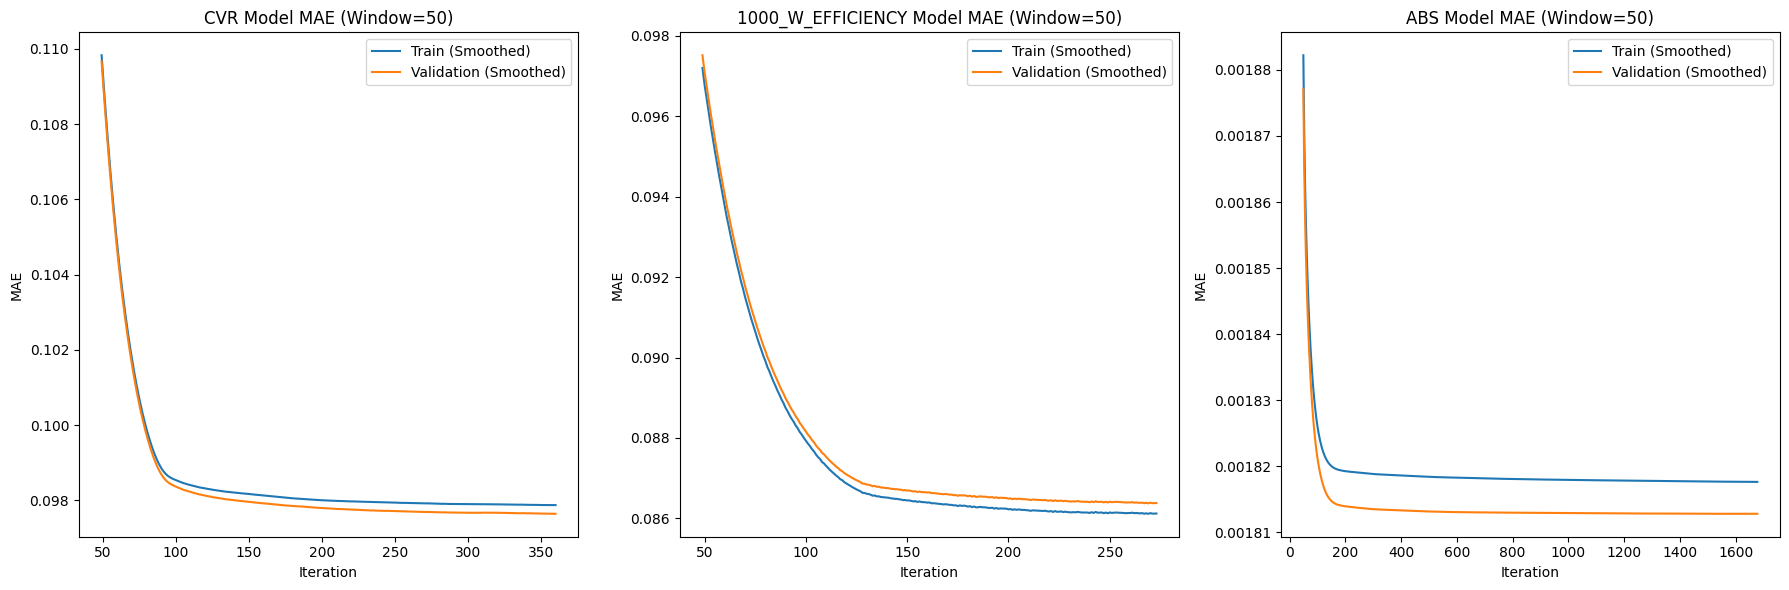

In [34]:
# CVR, CPA, ABS MAE 평가
res_cvr = results_0['CVR'].get_evals_result()
res_eff = results_0['1000_W_EFFICIENCY'].get_evals_result()
res_abs = results_0['ABS'].get_evals_result()

window_size = 50
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# CVR Train/ Validation
train_mae_cvr = pd.Series(res_cvr['learn']['MAE'])
val_mae_cvr = pd.Series(res_cvr['validation']['MAE'])

axes[0].plot(train_mae_cvr.rolling(window=window_size).mean(), label='Train (Smoothed)')
axes[0].plot(val_mae_cvr.rolling(window=window_size).mean(), label='Validation (Smoothed)')

axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('MAE')
axes[0].set_title(f'CVR Model MAE (Window={window_size})')
axes[0].legend()

# 100_W_EFFICIENCY Train/ Validation
train_mae_eff = pd.Series(res_eff['learn']['MAE'])
val_mae_eff = pd.Series(res_eff['validation']['MAE'])

axes[1].plot(train_mae_eff.rolling(window=window_size).mean(), label='Train (Smoothed)')
axes[1].plot(val_mae_eff.rolling(window=window_size).mean(), label='Validation (Smoothed)')

axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('MAE')
axes[1].set_title(f'1000_W_EFFICIENCY Model MAE (Window={50})')
axes[1].legend()

# ABS Train/ Validation
train_mae_abs = pd.Series(res_abs['learn']['MAE'])
val_mae_abs = pd.Series(res_abs['validation']['MAE'])

axes[2].plot(train_mae_abs.rolling(window=window_size).mean(), label='Train (Smoothed)')
axes[2].plot(val_mae_abs.rolling(window=window_size).mean(), label='Validation (Smoothed)')

axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('MAE')
axes[2].set_title(f'ABS Model MAE (Window={window_size})')
axes[2].legend()
plt.tight_layout()
plt.show()